In [1]:
%matplotlib inline
import networkx as nx
import metis
import random
import pandas as pd
from tqdm import tqdm
from itertools import chain
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from time import time
from leopard import update_partition

In [2]:
# update rwc score
from rwc import populate_r_and_c
def controversy_score(g, parts, top_percent=0.001, nstart0=None, nstart1=None):
    """consider only two sides only                               
    
    parts: list of cluster ids, the partitioning information, 
    
    top_percent: percentage of high degree nodes to consider for the c vector           
    
    nstart1, nstart2: the nstart parameter in networkx.pagerank for both sides
        if None, then start from scratch
        
    returns:
    
    rwc_score
    
    aux_info: for example, pagerank for both sides
    """
    k = int(g.number_of_nodes() * top_percent)
    if k == 0:
        raise ValueError('only contains {} nodes, does not work for percent {}'.format(
            g.number_of_nodes(), top_percent))

    # cuts, parts = metis.part_graph(g)
    aux = lambda p, target: int(target == p)
                                                                                                                                                              
    # personalization vector                                                                                                                                  
    part_sizes = Counter(parts)
    e_0 = {n: aux(p, 0) / part_sizes[0] for n, p in zip(g.nodes(), parts)}
    e_1 = {n: aux(p, 1) / part_sizes[1] for n, p in zip(g.nodes(), parts)}
                                                                                                                                                              
    # pagerank scores                                                                                                                                         
    pr0 = nx.pagerank(g, alpha=0.85, personalization=e_0, dangling=e_0, max_iter=10000, nstart=nstart0)
    pr1 = nx.pagerank(g, alpha=0.85, personalization=e_1, dangling=e_1, max_iter=10000, nstart=nstart1)

    # nodes at two sides                                                                                                                                      
    nodes0 = [n for n, p in zip(g.nodes(), parts) if p == 0]
    nodes1 = [n for n, p in zip(g.nodes(), parts) if p == 1]

    r0, c0 = populate_r_and_c(g, pr0, nodes0, k)
    r1, c1 = populate_r_and_c(g, pr1, nodes1, k)

    r_list = [r0, r1]
    c_list = [c0, c1]
    rwc = 0
    k = len(r_list)
    for i, r in enumerate(r_list):
        for j, c in enumerate(c_list):
            prod = np.sum(r * c)
            # print(prod, prod * part_sizes[i])    
            if i == j:
                rwc += (prod * part_sizes[i])
            else:
                rwc -= (prod * part_sizes[i])
    rwc /= sum(part_sizes.values())
    aux_info = {
        'pr0': pr0,
        'pr1': pr1
    }
    return rwc, aux_info

            

In [14]:
run_job('data/beefban.gpkl')

{'name': 'beefban',
 'running_time_inc': 8.445266962051392,
 'running_time_raw': 10.667040586471558,
 'rwc_inc': 0.21943359624186259,
 'rwc_raw': 0.20770572191934478}

In [15]:
# running time and rwc score comparison
from util import sample_edges_to_add

def run_job(graph_pickle_path, edges_percent=0.1):
    g = nx.read_gpickle(graph_pickle_path)

    n_edges_to_add = n_edges_to_remove = int(g.number_of_edges() * edges_percent)
    edges_to_add = sample_edges_to_add(g, n_edges_to_add)
    edges_to_remove = random.sample(g.edges(), n_edges_to_remove)


    stat = {
        'name': os.path.basename(graph_pickle_path).split('.')[0]
    }
    cuts, node_cluster_ids = metis.part_graph(g, 2)
    rwc, aux_info = controversy_score(g, node_cluster_ids, 0.01)
    pr0, pr1 = aux_info['pr0'], aux_info['pr1']


    # update partition
    cuts, node_cluster_ids = metis.part_graph(g, 2)
    node_cluster_ids_inc = update_partition(g, node_cluster_ids=node_cluster_ids,
                                        edges_to_add=edges_to_add, edges_to_remove=edges_to_remove,
                                        verbose=False)
    pr0_new = {n: pr0[n] for n in g.nodes_iter()}
    pr1_new = {n: pr1[n] for n in g.nodes_iter()}

    s = time()
    rwc_inc, aux_info = controversy_score(g,
                                          node_cluster_ids_inc,
                                          0.01,
                                          nstart0=pr0_new, nstart1=pr1_new)

    stat['running_time_inc'] = time() - s
    stat['rwc_inc'] = rwc_inc

    _, node_cluster_ids_raw = metis.part_graph(g, 2)

    s = time()
    rwc_raw, aux_info = controversy_score(g, 
                                          node_cluster_ids_raw,
                                          0.01,
                                          nstart0=None, nstart1=None)
    stat['running_time_raw'] = time() - s
    stat['rwc_raw'] = rwc_raw
    return stat

In [16]:
from glob import glob
from joblib import Parallel, delayed
rows = Parallel(n_jobs=8)(delayed(run_job)(path) for path in glob('data/*.gpkl'))
# for path in glob('data/*.gpkl'):
#     run_job('data/beefban.gpkl')

In [17]:
df = pd.DataFrame.from_records(rows)

In [18]:
from scipy.stats import pearsonr
cc, p = pearsonr(df['rwc_inc'], df['rwc_raw'])
print(cc, p)

0.994445283425 4.26692170169e-07


In [32]:
print('average running time reduction (percentage): {:.2f}'.format(((df['running_time_raw'] - df['running_time_inc']) / df['running_time_raw']).mean()))

average running time reduction (percentage): 0.18


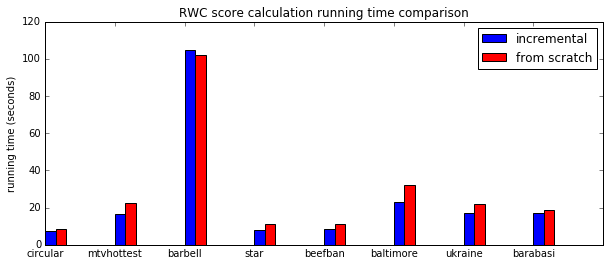

In [20]:
fig, ax = plt.subplots()
ind = np.arange(df.shape[0])
width = 0.15
ax.bar(ind, df['running_time_inc'], width, color='b')
ax.bar(ind+width, df['running_time_raw'], width, color='r')
ax.set_xticklabels(df['name'])
ax.set_ylabel('running time (seconds)')
ax.legend(['incremental', 'from scratch'])
fig.set_figwidth(10)
ax.set_title('RWC score calculation running time comparison')